In [72]:
import os
import sys
import pickle
import numpy as np

# sys.path.append('/n/home04/aboesky/berger/Weird_Galaxies')
sys.path.append('/Users/adamboesky/Research/ay98/Weird_Galaxies')

import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rc('text', usetex=True)
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cmr10'  # Computer Modern Roman
mpl.rcParams['font.size'] = 12  # Adjust the font size as needed

# Get best model

In [60]:
grid_results = []
# for fname in os.listdir('/n/home04/aboesky/berger/Weird_Galaxies/grid_search/results'):
for fname in os.listdir('/Users/adamboesky/Research/ay98/Weird_Galaxies/grid_search/results'):
    with open(f'/Users/adamboesky/Research/ay98/Weird_Galaxies/grid_search/results/{fname}', 'rb') as f:
        grid_results.append(pickle.load(f))

In [61]:
# Get the best loss
best_loss = {'test': np.inf, 'train': np.inf}
best_params = None
for params, loss in grid_results:
    if np.min(loss['test']) < np.min(best_loss['test']):
        best_params = params
        best_loss = loss

print(f'The best parameter combination in our grid search are:\n\nbatch_size, nodes_per_layer, num_linear_output_layers, learning_rate\n{best_params[::-1]}')

The best parameter combination in our grid search are:

batch_size, nodes_per_layer, num_linear_output_layers, learning_rate
[4096, [18, 15, 12, 9, 6, 4], 3, 0.01]


# Plots

## Loss v. Epoch

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_15000/3927947103.py:5: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.yscale('log')


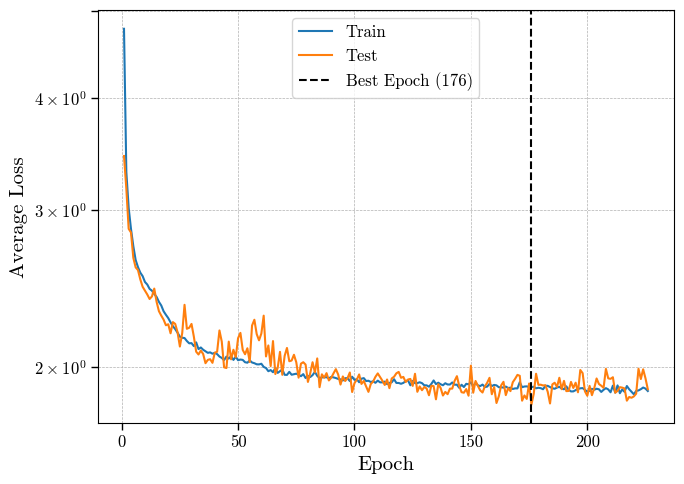

In [62]:
from matplotlib.ticker import LogLocator

plt.figure(figsize=(7, 5))
epochs = np.arange(1, len(best_loss['train']) + 1, 1)
plt.yscale('log')
plt.plot(epochs, best_loss['train'], label='Train')
plt.plot(epochs, best_loss['test'], label='Test')

# Make ticks bigger
plt.tick_params(axis='y', which='major', length=7, width=1)  # Adjust major tick size
plt.tick_params(axis='x', which='major', length=5, width=1)  # Adjust major tick size
plt.tick_params(axis='y', which='minor', length=5, width=1)  # Adjust minor tick size
best_epoch = np.argmin(best_loss['test']) + 1
plt.axvline(x=best_epoch, linestyle='--', color='k', label=f'Best Epoch ({best_epoch})')
plt.grid(True, which="both", ls="--", lw=0.5)

plt.ylabel('Average Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/best_loss_v_epoch.png', dpi=1000)
plt.show()

In [63]:
arg_test_min = np.argmin(best_loss['test'])
print(f'Minimum loss values:\n\ttest={best_loss["test"][arg_test_min]}\n\ttrain={best_loss["train"][arg_test_min]}')

Minimum loss values:
	test=1.8185034560579045
	train=1.9018249076566078


## Real v. Pred

In [64]:
sys.path.append('/Users/adamboesky/Research/ay98/Weird_Galaxies')
import torch
import seaborn as sns
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve
from neural_net import resume, CustomLoss, get_model, load_and_preprocess, normalize_arr
PATH_TO_CLEAN_DATA = '/Users/adamboesky/Research/ay98/clean_data'

In [65]:
# Get best model based on grid search
n_epochs = 1000
nodes_per_layer = [18, 15, 12, 9, 6, 4]
num_linear_output_layers = 3
learning_rate = 0.01
batch_size = 4096
torch.set_default_dtype(torch.float64)
model = get_model(num_inputs=18, num_outputs=3, nodes_per_layer=nodes_per_layer, num_linear_output_layers=num_linear_output_layers)
loss_fn = CustomLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
resume(model, '/Users/adamboesky/Research/ay98/Weird_Galaxies/best_model.pkl')
model.eval()

Sequential(
  (input): Linear(in_features=18, out_features=18, bias=True)
  (act_input): ReLU()
  (layer_0): Linear(in_features=18, out_features=15, bias=True)
  (act_0): ReLU()
  (layer_1): Linear(in_features=15, out_features=12, bias=True)
  (act_1): ReLU()
  (layer_2): Linear(in_features=12, out_features=9, bias=True)
  (act_2): ReLU()
  (layer_3): Linear(in_features=9, out_features=6, bias=True)
  (act_3): ReLU()
  (layer_4): Linear(in_features=6, out_features=4, bias=True)
  (act_4): ReLU()
  (pre_output0): Linear(in_features=4, out_features=4, bias=True)
  (pre_output1): Linear(in_features=4, out_features=4, bias=True)
  (output): Linear(in_features=4, out_features=3, bias=True)
)

In [66]:
# Load and preprocess the data for the NN
with open(os.path.join(PATH_TO_CLEAN_DATA, 'all_photometry.pkl'), 'rb') as f:
    all_photo = pickle.load(f)
photo = all_photo['data']
photo_err = all_photo['data_err']

# Take log of the fluxes to make the distributions better
photo_err = np.abs(photo_err / (photo * np.log(10)))
photo = np.log10(photo)

with open(os.path.join(PATH_TO_CLEAN_DATA, 'all_cat.pkl'), 'rb') as f:
    all_cat = pickle.load(f)
cat = all_cat['data']
print(f'Fixing the error for {np.sum(all_cat["data_err"][:, 2] == 0.01)} objects')
all_cat['data_err'][:, 2][all_cat['data_err'][:, 2] == 0.01] = 0.001 # Drop the spectroscopic errors down from the already low error
cat_err = all_cat['data_err']

print('Importing photometry data')
# Filter out z>1
z_local_mask = cat[:, 2] <= 1
photo = photo[z_local_mask]
photo_err = photo_err[z_local_mask]
cat = cat[z_local_mask]
cat_err = cat_err[z_local_mask]


######################## PRE PROCESSING ########################
# Filter out nans
nan_mask = np.isnan(cat).any(axis=1)
photo_norm, photo_mean, photo_std, photo_err_norm = normalize_arr(photo[~nan_mask], errors=photo_err[~nan_mask])
cat_norm, cat_mean, cat_std, cat_err_norm = normalize_arr(cat[~nan_mask], errors=cat_err[~nan_mask])
print('HEEERRRREE', cat_norm)
print(cat_mean)
print(f'Photo stats:\n \tmean = {photo_mean}\n \tstd = {photo_std}')
print(f'Catalog stats:\n \tmean = {cat_mean}\n \tstd = {cat_std}')
print(f'Length = {len(photo)}')

Fixing the error for 96514 objects
Importing photometry data
HEEERRRREE [[ 0.70927392  1.25512957  0.2270539 ]
 [-0.33256743  0.67634887  0.87570289]
 [-0.2748967   0.76784266  0.57368643]
 ...
 [ 0.60130756 -0.66104664  0.7521507 ]
 [-1.06907597 -0.30847975 -0.19851475]
 [-0.32610561 -0.29959755 -0.82657171]]
[ 8.69840122 -0.65829206  0.56184221]
Photo stats:
 	mean = [-2.88750664 -2.80485236 -2.79177703 -2.64890962 -2.69422682 -1.33202668
  0.06717019  0.67723176  1.35547094  0.92884049  1.34127727  1.21686633
  1.33390055 -2.42786271 -2.2128036  -1.99193711 -3.04366902 -3.0434582 ]
 	std = [0.6256189  0.69351311 0.67564669 0.71696901 0.78423232 0.88506622
 1.62868632 2.06807325 0.43284611 1.35729201 0.49397298 0.43336611
 0.45556757 2.21415807 2.12945886 2.02186998 0.66726908 0.69343955]
Catalog stats:
 	mean = [ 8.69840122 -0.65829206  0.56184221]
 	std = [1.31209275 1.35189867 0.29137484]
Length = 1261630


In [67]:
photo_train, photo_test, cat_train, cat_test, photo_err_train, photo_err_test, cat_err_train, cat_err_test = \
    train_test_split(photo_norm, cat_norm, photo_err_norm, cat_err_norm, shuffle=True, test_size=0.2, random_state=22)

# Predict attributes for the galaxies that have SNe
model.eval()
gal_props_pred: torch.Tensor = model(torch.from_numpy(photo_test))
gal_props_pred_untrans = gal_props_pred.detach().numpy()

In [68]:
0.01 / cat_std

array([0.00762141, 0.007397  , 0.03432005])

In [147]:
print(len(cat_test))

252326


In [69]:
pd.DataFrame(cat_err_test[:, 2]).value_counts()

0.003432     16812
0.418705       425
0.437581       406
0.401545       390
0.408409       390
             ...  
2.332048         1
2.332048         1
6.905195         1
2.338912         1
10.091811        1
Name: count, Length: 11947, dtype: int64

In [70]:
photo_z_mask = cat_err_test[:, 2] > 0.01
print(np.sum(photo_z_mask))
all_mask = np.ones(len(cat_test)) == 1

235514


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_15000/1680878108.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Adjust figsize as needed
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_15000/1680878108.py:15: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(heatmap).T, extent=extent, origin='lower', aspect='auto', cmap='Blues')
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_15000/1680878108.py:38: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar_ax = fig.add_axes([0.92, 0.53, 0.02, 0.37])  # Adjust the position and size as needed
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_15000/1680878108.py:39: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = fig.colorbar(im, cax=cbar_ax, fr

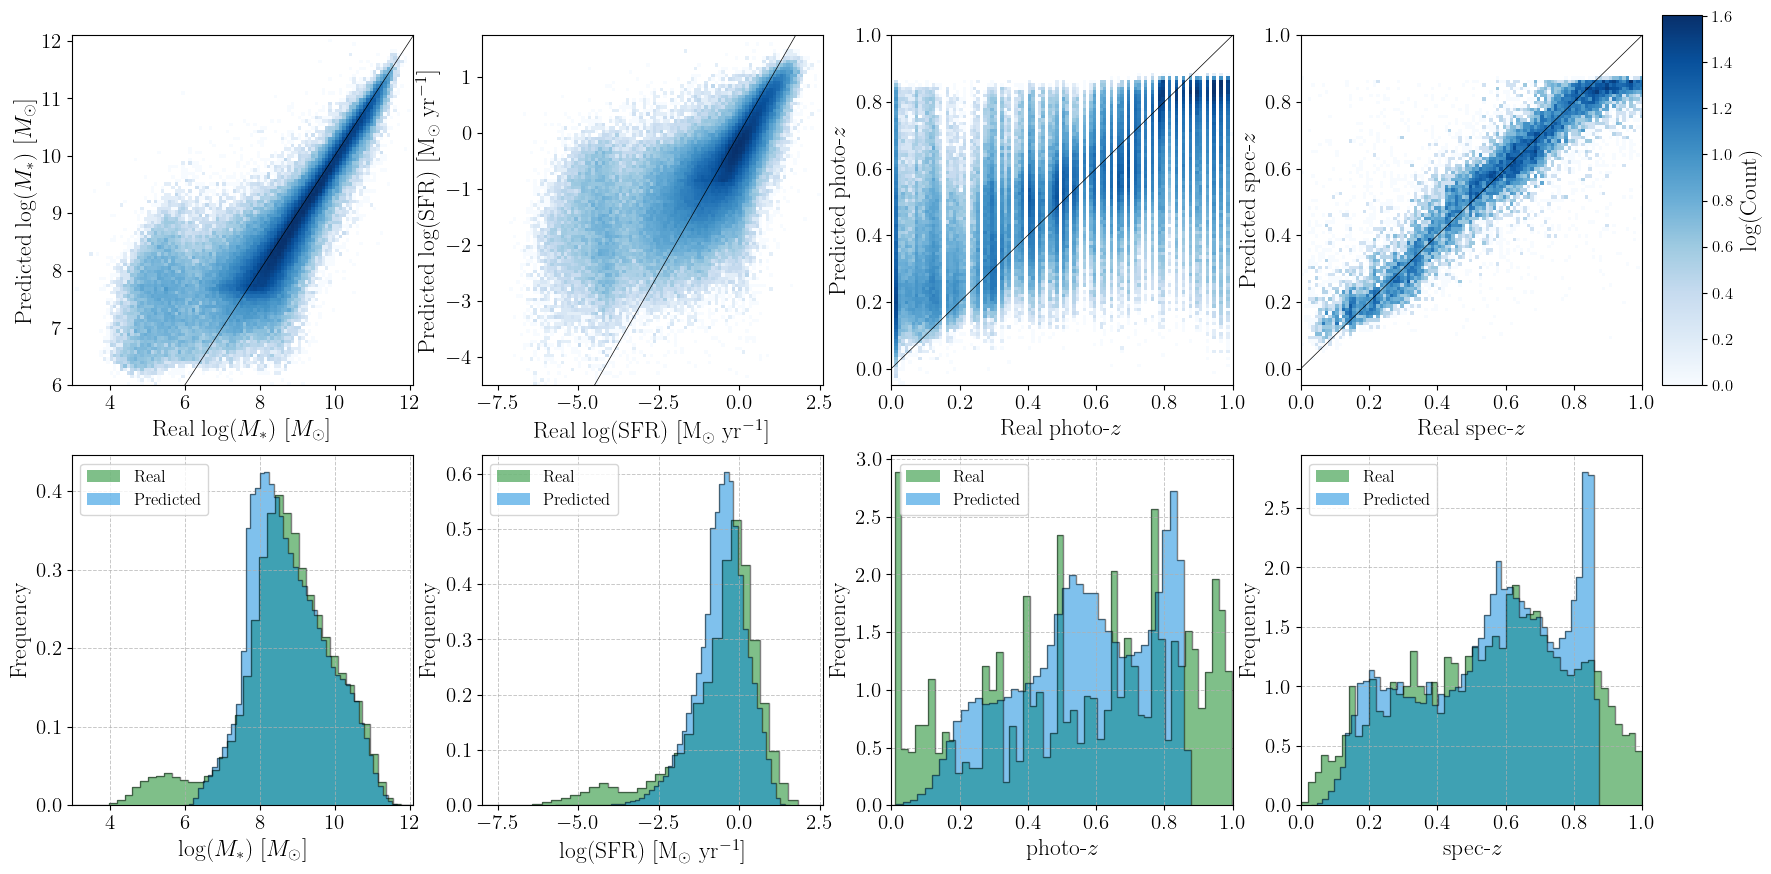

In [78]:
# Real v pred heatmaps
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Adjust figsize as needed
pred = gal_props_pred_untrans * cat_std + cat_mean
real = cat_test * cat_std + cat_mean
params = [r'$\log(M_*) \ [M_\odot]$', r'$\log(\rm{SFR}) \ [M_\odot \ \rm{yr}^{-1}]$', r'photo-$z$', r'spec-$z$']
xlims = [(3, 12.1), (-8, 2.6), (0, 1), (0, 1)]
ylims = [(6, 12.1), (-4.5, 1.75), (-0.05, 1), (-0.05, 1)]
masks = [all_mask, all_mask, photo_z_mask, ~photo_z_mask]

for i, (param, xlim, ylim, ax, mask) in enumerate(zip(params, xlims, ylims, axes[0], masks)):
    if i == 3:
        i -= 1
    heatmap, xedges, yedges = np.histogram2d(real[:, i][mask], pred[:, i][mask], bins=(100, 100), range=[xlim, ylim])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = ax.imshow(np.log10(heatmap).T, extent=extent, origin='lower', aspect='auto', cmap='Blues')
    ax.axline((0, 0), slope=1, color='black', linewidth=0.5)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(fr'Real {param}', fontsize=17)
    ax.set_ylabel(fr'Predicted {param}', fontsize=17)
    ax.tick_params(axis='both', which='major', labelsize=15)

for i, (param, ax, lim, mask) in enumerate(zip(params, axes[1], xlims, masks)):
    if i == 3:
        i -= 1
    ax.hist(real[:, i][mask], label='Real', alpha=0.5, density=True, bins=50, color='#008114')
    ax.hist(real[:, i][mask], alpha=0.5, density=True, bins=50, color='k', histtype='step')
    ax.hist(pred[:, i][mask], label='Predicted', alpha=0.5, density=True, bins=50, color='#0084DD')
    ax.hist(pred[:, i][mask], alpha=0.5, density=True, bins=50, color='k', histtype='step')
    ax.set_xlabel(param, fontsize=17)
    ax.set_ylabel(r'Frequency', fontsize=17)
    ax.legend(loc='upper left')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, zorder=-1)
    ax.set_xlim(lim)

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.53, 0.02, 0.37])  # Adjust the position and size as needed
cbar = fig.colorbar(im, cax=cbar_ax, fraction=1.5)
cbar.set_label(r'$\log(\rm{Count})$', fontsize=17)  # Adjust fontsize as needed
plt.subplots_adjust(right=0.91)
plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/real_v_preds.png', bbox_inches='tight', dpi=600)
plt.show()

# Fractional Error

In [89]:
# Get the median fractional error
frac_errs = []
errs = []
for i, (r, p) in enumerate(zip(real.T, pred.T)):
    frac_errs.append(np.abs((r - p) / r))
    errs.append(np.abs((r - p)))

errs = np.array(errs)
frac_errs = np.array(frac_errs)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_15000/3242540889.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(photoz_frac_err, bins=np.linspace(0, 5, num=50))


Photo-z fractional error = 0.18382066591655388
Photo-z  error = 0.11071792311154513


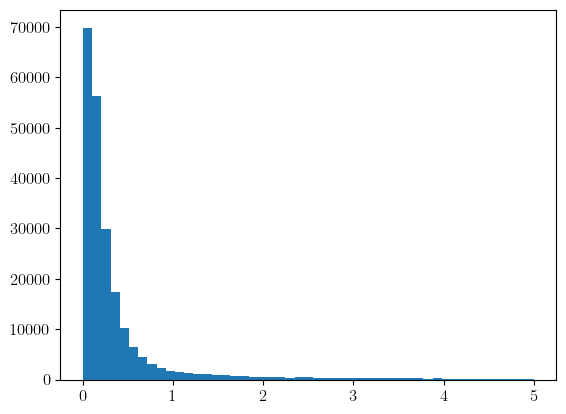

In [156]:
photoz_frac_err = np.abs((real[:, 2][photo_z_mask] - pred[:, 2][photo_z_mask]) / real[:, 2][photo_z_mask])
photoz_err = np.abs((real[:, 2][photo_z_mask] - pred[:, 2][photo_z_mask]))
plt.hist(photoz_frac_err, bins=np.linspace(0, 5, num=50))
print(f'Photo-z fractional error = {np.median(photoz_frac_err)}')
print(f'Photo-z  error = {np.median(photoz_err)}')

In [121]:
print(np.nansum(frac_errs[0] > 2))
print(np.nansum(frac_errs[1] > 10000))
print(np.nansum(frac_errs[2] > 100))

3
12
2


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_15000/483432713.py:4: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(errs[i], bins=50)


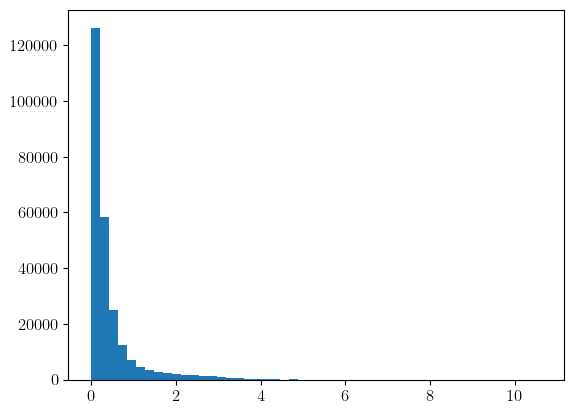

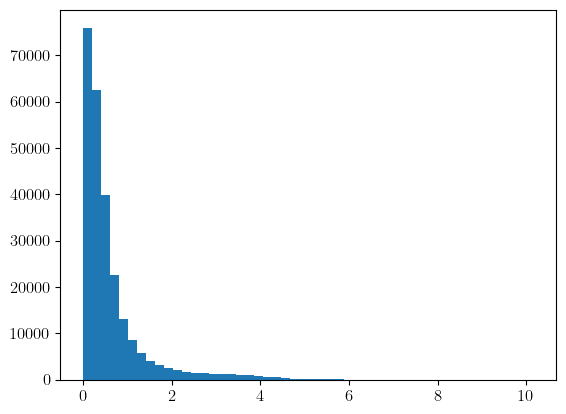

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_15000/483432713.py:4: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(errs[i], bins=50)


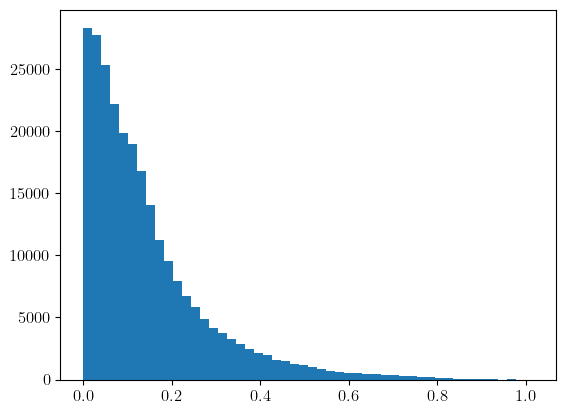

In [132]:
params = [r'$\log(M_*) \ [M_\odot]$', r'$\log(\rm{SFR}) \ [M_\odot \ \rm{yr}^{-1}]$', r'$z$']
xmax = [2, 20, 20]
for i, (param, xm) in enumerate(zip(params, xmax)):
    plt.hist(errs[i], bins=50)
    plt.show()

In [146]:
print(f'Fractional Error:\n\tmean = {np.mean(frac_errs, axis=1).round(4)} \n\tmedian = {np.median(frac_errs, axis=1).round(4)} \n\tstdev = {np.std(frac_errs, axis=1).round(4)}\n\n')
print(f'Error:\n\tmean = {np.mean(errs, axis=1).round(4)} \n\tmedian = {np.median(errs, axis=1).round(4)} \n\tstdev = {np.std(errs, axis=1).round(4)}\n\n')

print(f'Measured Uncertainties:\n\tmean = \t{np.mean(cat_err_test, axis=0).round(4)}\n\tmedian = {np.median(cat_err_test, axis=0).round(4)}\n\tstdev = {np.std(cat_err_test, axis=0).round(4)}\n\n')

print(f'Prediction RMSE = {np.sqrt(np.mean(errs**2, axis=1).round(4)).round(4)}')
print(f'Measured uncertainty/true value = {np.abs(np.mean(cat_err_test / cat_test, axis=0).round(4))}')

Fractional Error:
	mean = [0.0582 4.698  2.2956] 
	median = [0.0236 0.5882 0.1747] 
	stdev = [1.078000e-01 2.217568e+02 1.016295e+02]


Error:
	mean = [0.4092 0.6015 0.1436] 
	median = [0.2121 0.3607 0.105 ] 
	stdev = [0.5722 0.7491 0.1363]


Measured Uncertainties:
	mean = 	[0.1839 0.3254 1.4333]
	median = [0.1626 0.2399 0.5543]
	stdev = [0.102  0.2865 1.9451]


Prediction RMSE = [0.7035 0.9607 0.198 ]
Measured uncertainty/true value = [0.3975 0.251  0.8293]
